In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load data
try:
    df = pd.read_csv('/content/Education in Africa.csv')
    print("INITIAL DATA INFO")
    print("="*60)
    print(f"Shape: {df.shape}")
    print(f"\nColumns:\n{df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
except FileNotFoundError:
    print("ERROR: The file 'Education in Africa.csv' was not found.")
    print("Please upload the 'Education in Africa.csv' file to your Colab environment or ensure the path is correct.")
    print("You can upload it using the files icon on the left sidebar (Files -> Upload to session storage),")
    print("or by running the following Python code in a new cell:")
    print("  from google.colab import files")
    print("  uploaded = files.upload()")
    print("  # Then try running this cell again after uploading.")
    df = None # Set df to None to indicate failure to load
except UnicodeDecodeError:
    print("ERROR: UnicodeDecodeError encountered while reading the CSV. Trying 'latin1' encoding...")
    try:
        df = pd.read_csv('/content/Education in Africa.csv', encoding='latin1')
        print("INITIAL DATA INFO (with latin1 encoding)")
        print("="*60)
        print(f"Shape: {df.shape}")
        print(f"\nColumns:\n{df.columns.tolist()}")
        print(f"\nFirst few rows:")
        print(df.head())
    except Exception as e:
        print(f"ERROR: Failed to read CSV even with 'latin1' encoding: {e}")
        print("Please check the file's encoding or its integrity.")
        df = None


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# STEP 1: DATA CLEANING - Convert to Numeric
# ============================================
print("STEP 1: CONVERTING OBJECT COLUMNS TO NUMERIC")
print("="*60)

# List of columns that should be numeric
numeric_cols = [
    'School life expectancy, primary to tertiary, male (years)',
    'School life expectancy, primary to tertiary, female (years)',
    'Government expenditure on primary education, US$ (millions)',
    'Government expenditure on secondary education, US$ (millions)',
    'Government expenditure on tertiary education, US$ (millions)',
    'Government expenditure on primary education as a percentage of GDP (%)',
    'Government expenditure on secondary education as a percentage of GDP (%)',
    'Government expenditure on tertiary education as a percentage of GDP (%)'
]

# Convert to numeric, forcing errors to NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("✓ Converted columns to numeric")
print(f"\nData types after conversion:")
print(df.dtypes)

# Check for missing values NOW
print("\n" + "="*60)
print("MISSING VALUES AFTER CONVERSION")
print("="*60)
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])
print(f"\nTotal missing: {df.isna().sum().sum()}")
print(f"Percentage missing: {(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

STEP 1: CONVERTING OBJECT COLUMNS TO NUMERIC
✓ Converted columns to numeric

Data types after conversion:
ISO_Code                                                                     object
Country                                                                      object
Year                                                                          int64
School life expectancy, primary to tertiary, male (years)                   float64
School life expectancy, primary to tertiary, female (years)                 float64
Government expenditure on primary education, US$ (millions)                 float64
Government expenditure on secondary education, US$ (millions)               float64
Government expenditure on tertiary education, US$ (millions)                float64
Government expenditure on primary education as a percentage of GDP (%)      float64
Government expenditure on secondary education as a percentage of GDP (%)    float64
Government expenditure on tertiary education as a perc

In [ ]:

# STEP 2: FEATURE ENGINEERING & TARGET SELECTION
# ============================================
print("STEP 2: FEATURE ENGINEERING")
print("="*60)

# Rename columns for easier handling
df.rename(columns={
    'School life expectancy, primary to tertiary, male (years)': 'school_life_male',
    'School life expectancy, primary to tertiary, female (years)': 'school_life_female',
    'Government expenditure on primary education, US$ (millions)': 'exp_primary_usd',
    'Government expenditure on secondary education, US$ (millions)': 'exp_secondary_usd',
    'Government expenditure on tertiary education, US$ (millions)': 'exp_tertiary_usd',
    'Government expenditure on primary education as a percentage of GDP (%)': 'exp_primary_gdp',
    'Government expenditure on secondary education as a percentage of GDP (%)': 'exp_secondary_gdp',
    'Government expenditure on tertiary education as a percentage of GDP (%)': 'exp_tertiary_gdp'
}, inplace=True)

# Create derived features
df['avg_school_life'] = (df['school_life_male'] + df['school_life_female']) / 2
df['total_exp_usd'] = df['exp_primary_usd'] + df['exp_secondary_usd'] + df['exp_tertiary_usd']
df['total_exp_gdp'] = df['exp_primary_gdp'] + df['exp_secondary_gdp'] + df['exp_tertiary_gdp']
df['gender_gap_education'] = df['school_life_male'] - df['school_life_female']

print("✓ Created derived features:")
print("  - avg_school_life (average of male & female)")
print("  - total_exp_usd (sum of all USD expenditures)")
print("  - total_exp_gdp (sum of all GDP % expenditures)")
print("  - gender_gap_education (male - female school life)")

STEP 2: FEATURE ENGINEERING
✓ Created derived features:
  - avg_school_life (average of male & female)
  - total_exp_usd (sum of all USD expenditures)
  - total_exp_gdp (sum of all GDP % expenditures)
  - gender_gap_education (male - female school life)


In [ ]:

# STEP 3: HANDLE MISSING VALUES
# ============================================
print("STEP 3: HANDLING MISSING VALUES")
print("="*60)

# Strategy: Drop rows with too many missing values, impute others
missing_threshold = 0.5  # Drop rows missing >50% of columns
df['missing_count'] = df.isna().sum(axis=1)
df['missing_pct'] = df['missing_count'] / len(df.columns)

print(f"Rows before cleaning: {len(df)}")
df_clean = df[df['missing_pct'] < missing_threshold].copy()
print(f"Rows after removing high-missing rows: {len(df_clean)}")

# For remaining missing values, use median imputation for numeric columns
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_clean[col].isna().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  ✓ Filled {col} with median: {median_val:.2f}")

# Drop helper columns
df_clean.drop(['missing_count', 'missing_pct'], axis=1, inplace=True)

print(f"\n✓ Final dataset shape: {df_clean.shape}")
print(f"✓ Remaining missing values: {df_clean.isna().sum().sum()}")

STEP 3: HANDLING MISSING VALUES
Rows before cleaning: 756
Rows after removing high-missing rows: 269
  ✓ Filled school_life_male with median: 11.25
  ✓ Filled school_life_female with median: 10.38
  ✓ Filled exp_primary_usd with median: 142.79
  ✓ Filled exp_secondary_usd with median: 111.00
  ✓ Filled exp_tertiary_usd with median: 74.13
  ✓ Filled exp_primary_gdp with median: 1.47
  ✓ Filled exp_secondary_gdp with median: 1.16
  ✓ Filled exp_tertiary_gdp with median: 0.67
  ✓ Filled Unnamed: 11 with median: nan
  ✓ Filled Unnamed: 12 with median: nan
  ✓ Filled avg_school_life with median: 10.83
  ✓ Filled total_exp_usd with median: 392.84
  ✓ Filled total_exp_gdp with median: 3.42
  ✓ Filled gender_gap_education with median: 0.38

✓ Final dataset shape: (269, 17)
✓ Remaining missing values: 538



STEP 4: EXPLORATORY DATA ANALYSIS

Descriptive Statistics:
              Year  school_life_male  school_life_female  exp_primary_usd  \
count   269.000000        269.000000          269.000000       269.000000   
mean   2014.531599         11.069257           10.478439       717.470000   
std       3.683860          1.833853            2.403143      1983.952074   
min    2010.000000          5.190000            4.030000         0.260000   
25%    2012.000000         10.610000            9.820000        86.180000   
50%    2014.000000         11.250000           10.380000       142.790000   
75%    2017.000000         11.710000           11.100000       369.660000   
max    2023.000000         17.070000           20.790000     10611.230000   

       exp_secondary_usd  exp_tertiary_usd  exp_primary_gdp  \
count         269.000000        269.000000       269.000000   
mean          588.679591        313.452602         1.589814   
std          1569.134573        815.213133         0.7291

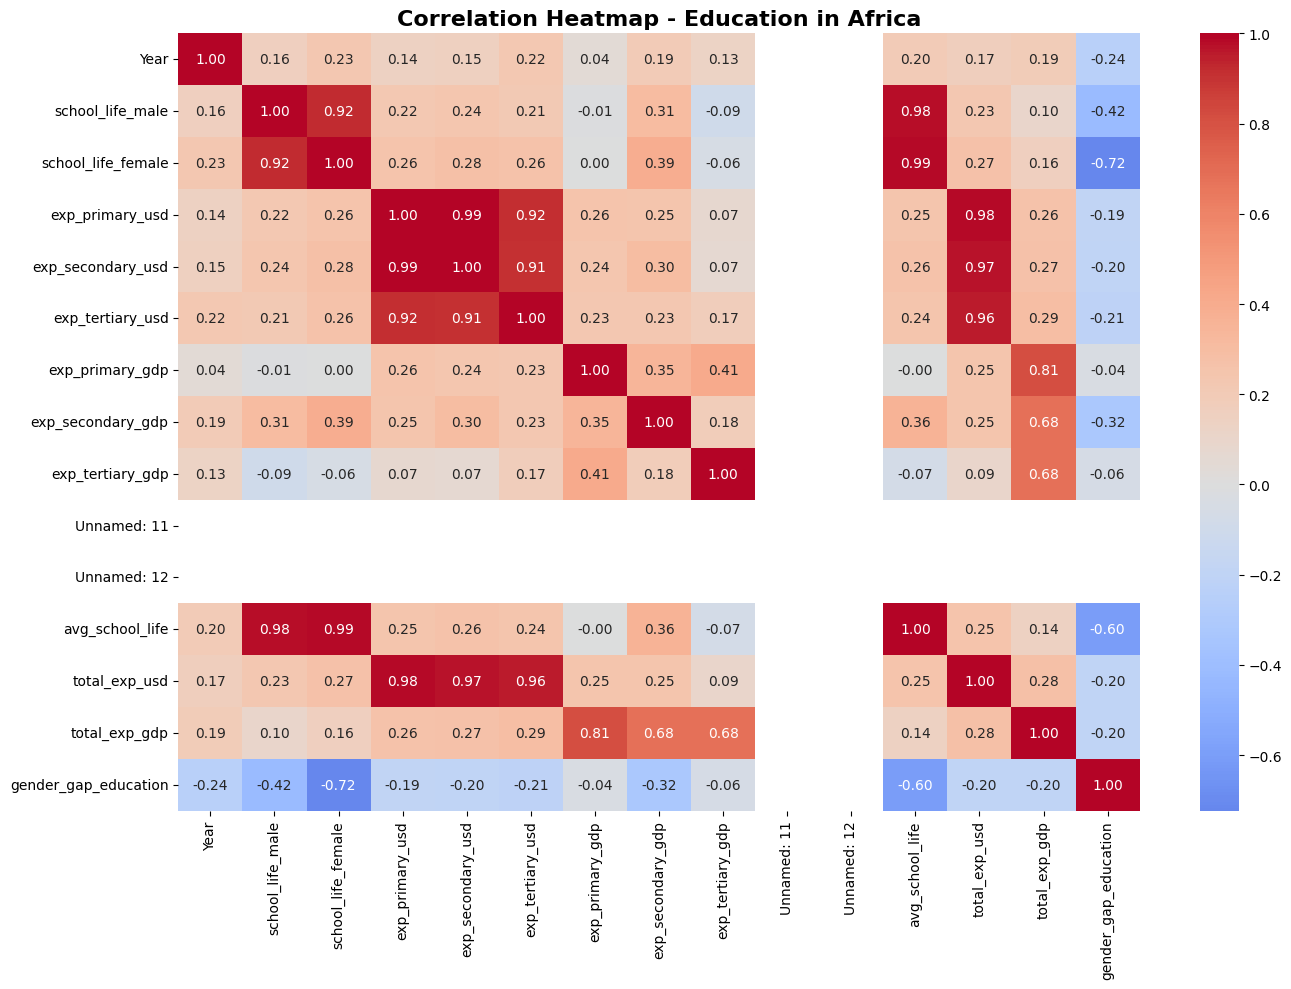

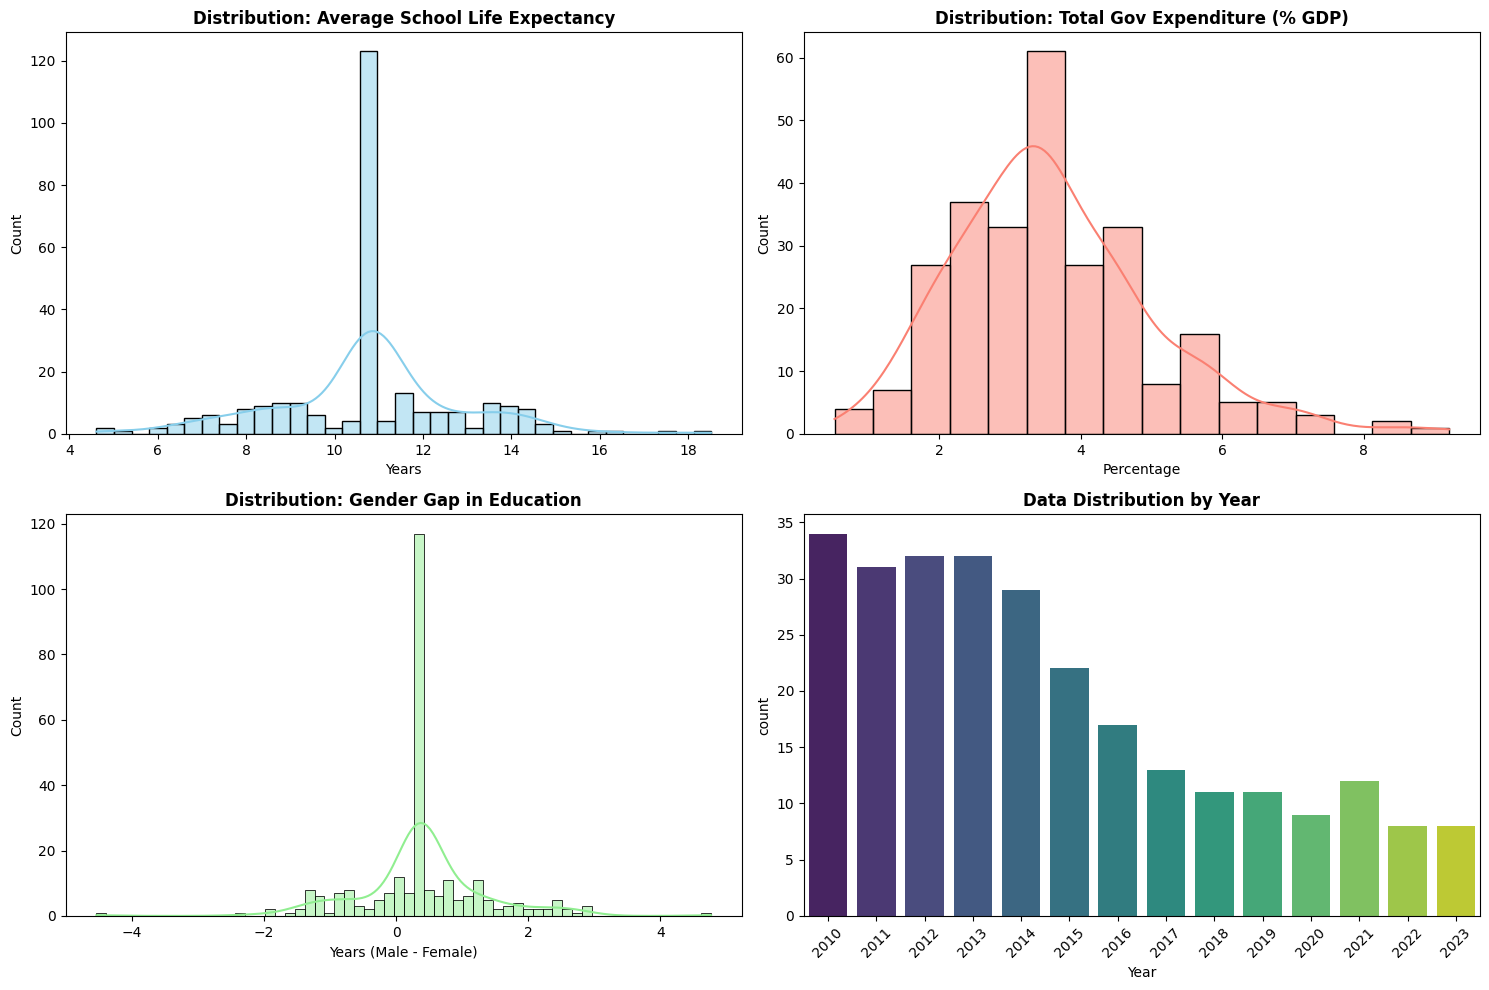


CORRELATIONS WITH TARGET (avg_school_life)
avg_school_life         1.000000
school_life_female      0.985623
school_life_male        0.975721
exp_secondary_gdp       0.362135
exp_secondary_usd       0.264730
total_exp_usd           0.254343
exp_primary_usd         0.247404
exp_tertiary_usd        0.244257
Year                    0.201673
total_exp_gdp           0.139491
exp_primary_gdp        -0.003560
exp_tertiary_gdp       -0.073319
gender_gap_education   -0.603870
Unnamed: 11                  NaN
Unnamed: 12                  NaN
Name: avg_school_life, dtype: float64


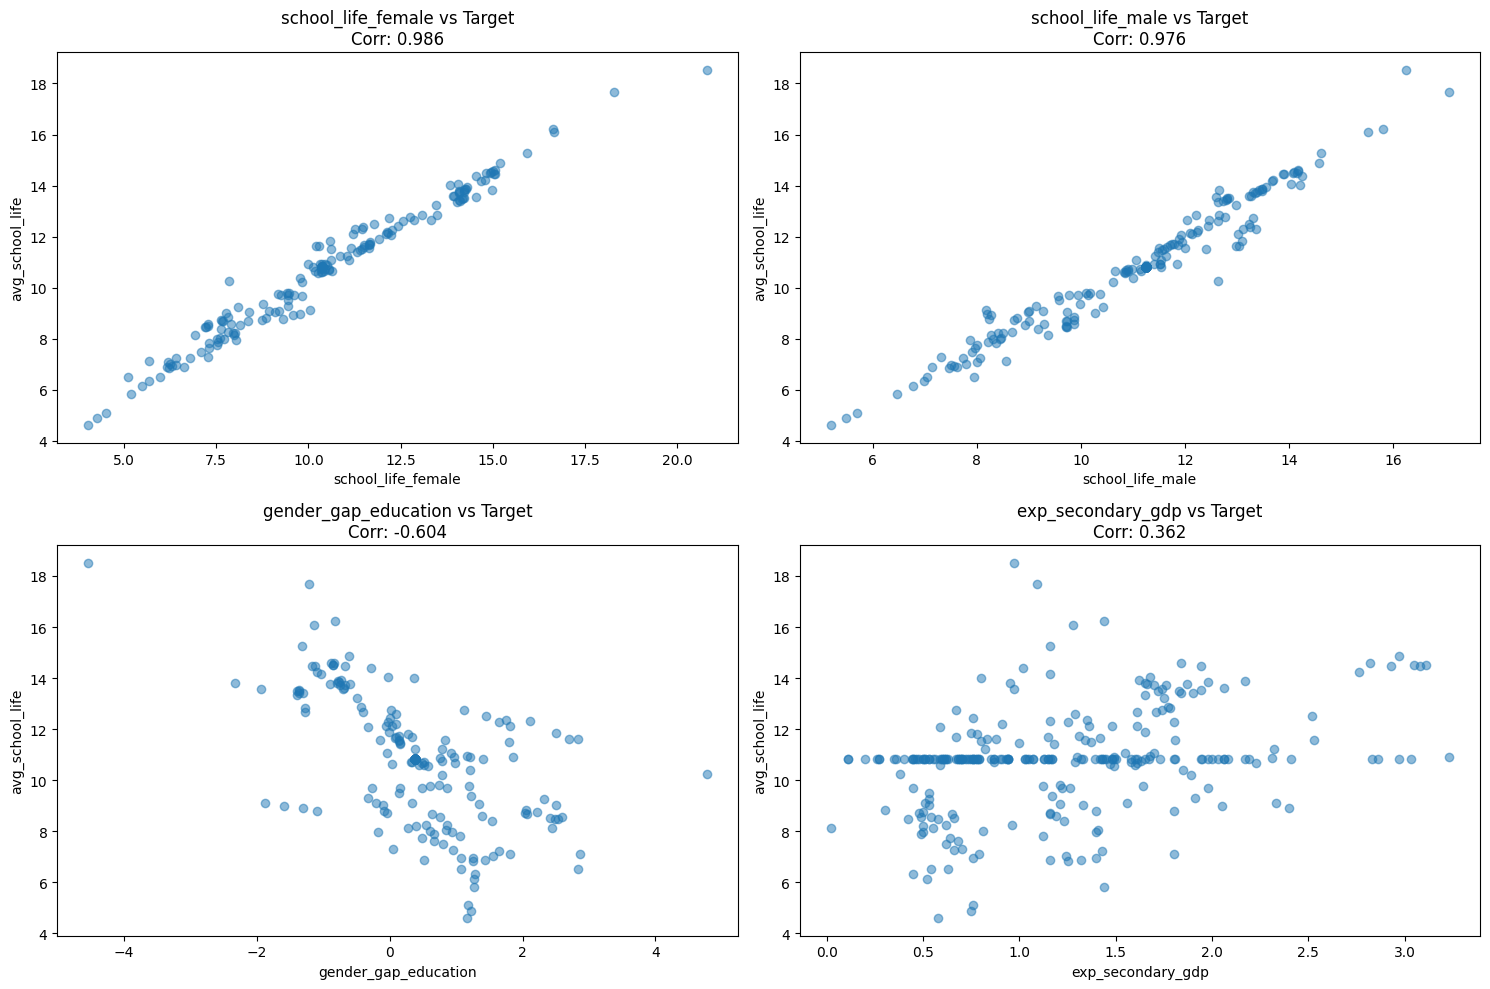


✓ EDA COMPLETE - Ready for modeling!
✓ Saved cleaned data to 'education_africa_cleaned.csv'


In [ ]:

# STEP 4: EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("STEP 4: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic statistics
print("\nDescriptive Statistics:")
print(df_clean.describe())

# Correlation heatmap
plt.figure(figsize=(14, 10))
numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Education in Africa', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution plots for key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Average School Life Expectancy
sns.histplot(df_clean['avg_school_life'].dropna(), kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution: Average School Life Expectancy', fontweight='bold')
axes[0, 0].set_xlabel('Years')

# Plot 2: Total Government Expenditure (GDP %)
sns.histplot(df_clean['total_exp_gdp'].dropna(), kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution: Total Gov Expenditure (% GDP)', fontweight='bold')
axes[0, 1].set_xlabel('Percentage')

# Plot 3: Gender Gap
sns.histplot(df_clean['gender_gap_education'].dropna(), kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution: Gender Gap in Education', fontweight='bold')
axes[1, 0].set_xlabel('Years (Male - Female)')

# Plot 4: Year distribution
sns.countplot(data=df_clean, x='Year', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Data Distribution by Year', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation with target (avg_school_life)
print("\n" + "="*60)
print("CORRELATIONS WITH TARGET (avg_school_life)")
print("="*60)
correlations = numeric_df.corr()['avg_school_life'].sort_values(ascending=False)
print(correlations)

# Scatter plots of top features vs target
top_features = correlations.drop('avg_school_life').abs().nlargest(4).index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(df_clean[feature], df_clean['avg_school_life'], alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('avg_school_life')
    axes[idx].set_title(f'{feature} vs Target\nCorr: {correlations[feature]:.3f}')

plt.tight_layout()
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✓ EDA COMPLETE - Ready for modeling!")
print("="*60)

# Save cleaned data
df_clean.to_csv('education_africa_cleaned.csv', index=False)
print("✓ Saved cleaned data to 'education_africa_cleaned.csv'")

EDUCATION IN AFRICA - PREDICTIVE MODELING
Mission: Predict School Life Expectancy Based on Government Investment

✓ Loaded cleaned dataset: (269, 17)

FEATURE SELECTION
Target Variable: avg_school_life
Features (5):
  - Year
  - exp_primary_gdp
  - exp_secondary_gdp
  - exp_tertiary_gdp
  - total_exp_gdp

✓ Final dataset for modeling: (269, 5)
✓ Target distribution: min=4.61, max=18.52, mean=10.78

TRAIN-TEST SPLIT
Training set: (215, 5)
Test set: (54, 5)

FEATURE STANDARDIZATION
✓ Features standardized (mean=0, std=1)
Scaler mean: [2.01454419e+03 1.58827907e+00 1.21055814e+00 7.54558140e-01
 3.54937209e+00]
Scaler scale: [3.66969375 0.71465088 0.64936081 0.53251895 1.39107745]
✓ Saved scaler to 'scaler.pkl'

MODEL 1: LINEAR REGRESSION
Train MSE: 3.5319
Test MSE:  3.5413
Train R²:  0.1934
Test R²:   0.1162

Feature Coefficients:
  Year                          :   0.2287
  exp_primary_gdp               :  -0.4976
  exp_secondary_gdp             :   0.6439
  exp_tertiary_gdp            

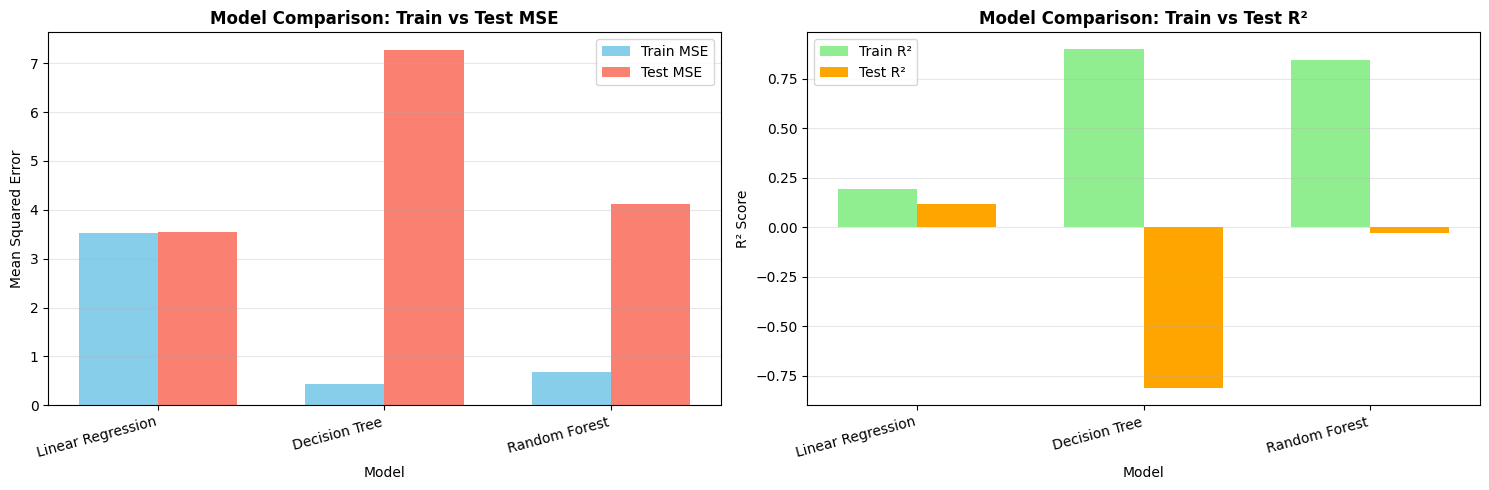

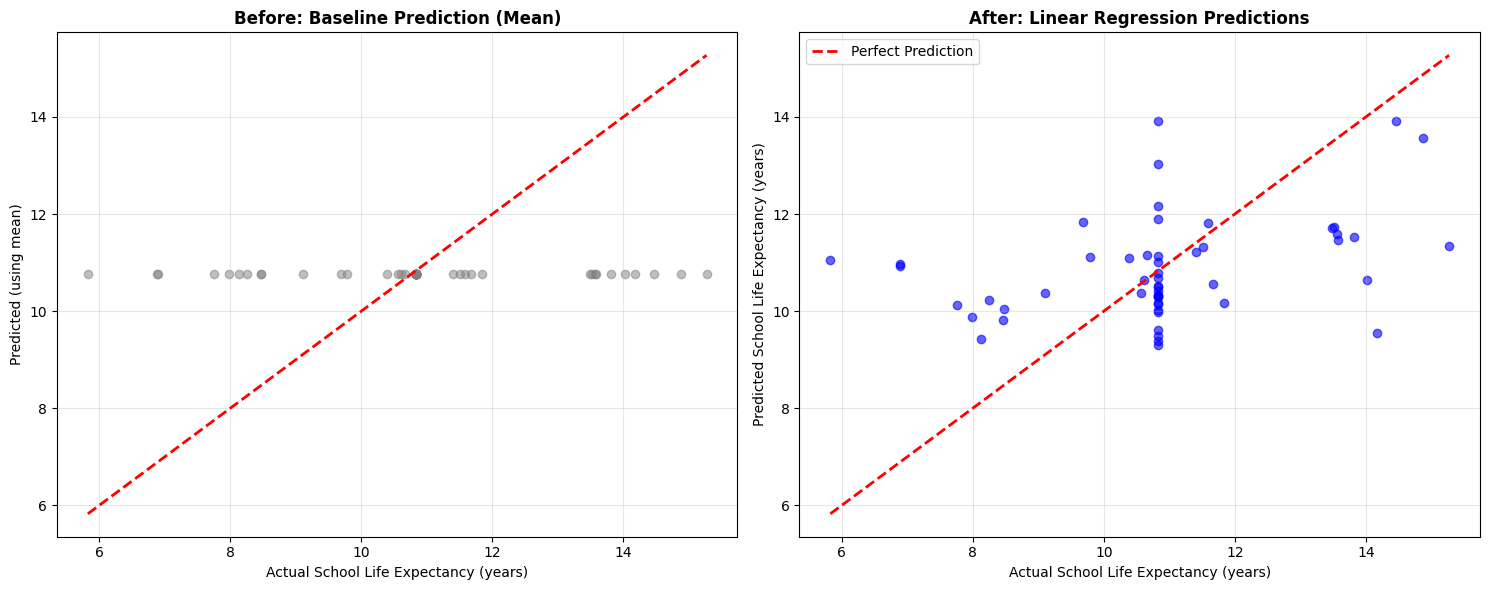

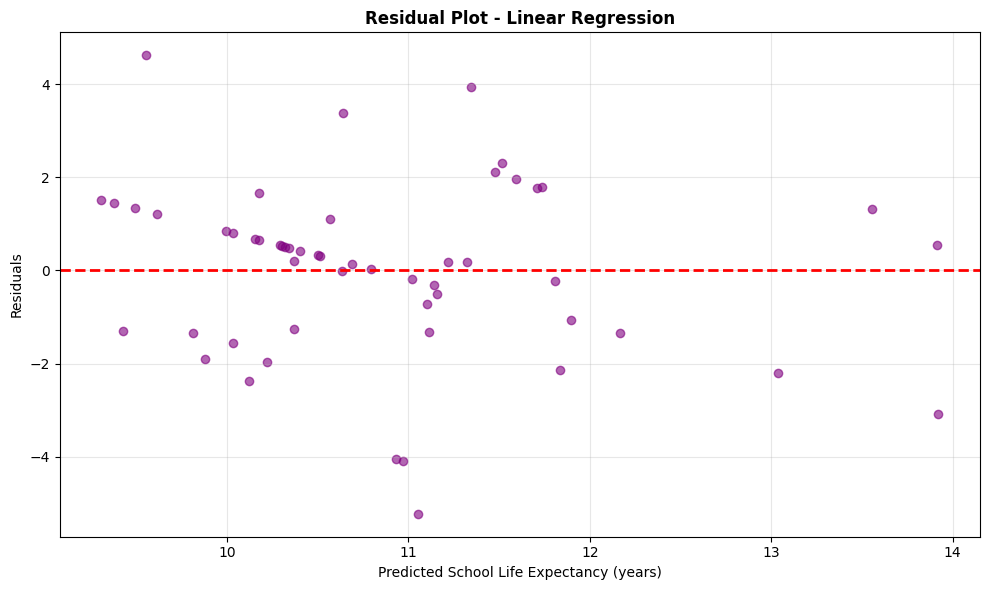


SAVING BEST MODEL
✓ Saved Linear Regression to 'best_model.pkl'
✓ Saved feature names to 'feature_names.pkl'

TEST PREDICTION ON SINGLE DATA POINT

Sample Input:
    Year  exp_primary_gdp  exp_secondary_gdp  exp_tertiary_gdp  total_exp_gdp
30  2010             1.47               1.16              1.68          3.415

Actual School Life Expectancy: 14.18 years
Predicted School Life Expectancy: 9.56 years
Error: 4.62 years

PREDICTION FUNCTION FOR API

✓ Test Prediction: 11.68 years

✓ MODELING COMPLETE!

Files saved:
  - best_model.pkl
  - scaler.pkl
  - feature_names.pkl
  - correlation_heatmap.png
  - distributions.png
  - feature_relationships.png
  - model_comparison.png
  - predictions_comparison.png
  - residuals.png


In [ ]:
print("="*70)
print("EDUCATION IN AFRICA - PREDICTIVE MODELING")
print("Mission: Predict School Life Expectancy Based on Government Investment")
print("="*70)

# ============================================
# LOAD CLEANED DATA
# ============================================
df = pd.read_csv('education_africa_cleaned.csv')
print(f"\n✓ Loaded cleaned dataset: {df.shape}")

# ============================================
# FEATURE SELECTION
# ============================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

# Target variable
target = 'avg_school_life'

# Features to use for prediction
features = [
    'Year',
    'exp_primary_gdp',
    'exp_secondary_gdp',
    'exp_tertiary_gdp',
    'exp_primary_usd',
    'exp_secondary_usd',
    'exp_tertiary_usd',
    'total_exp_gdp',
    'school_life_male',
    'school_life_female'
]

# Remove features that leak information about target
# (male/female school life are too closely related to average)
features_final = [
    'Year',
    'exp_primary_gdp',
    'exp_secondary_gdp',
    'exp_tertiary_gdp',
    'total_exp_gdp'
]

print(f"Target Variable: {target}")
print(f"Features ({len(features_final)}):")
for f in features_final:
    print(f"  - {f}")

# Prepare X and y
X = df[features_final].copy()
y = df[target].copy()

# Remove any remaining NaN
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\n✓ Final dataset for modeling: {X.shape}")
print(f"✓ Target distribution: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

# ============================================
# TRAIN-TEST SPLIT
# ============================================
print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ============================================
# FEATURE STANDARDIZATION
# ============================================
print("\n" + "="*70)
print("FEATURE STANDARDIZATION")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized (mean=0, std=1)")
print(f"Scaler mean: {scaler.mean_}")
print(f"Scaler scale: {scaler.scale_}")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Saved scaler to 'scaler.pkl'")

# ============================================
# MODEL 1: LINEAR REGRESSION
# ============================================
print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION")
print("="*70)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print(f"Train MSE: {lr_train_mse:.4f}")
print(f"Test MSE:  {lr_test_mse:.4f}")
print(f"Train R²:  {lr_train_r2:.4f}")
print(f"Test R²:   {lr_test_r2:.4f}")

# Feature importance (coefficients)
print("\nFeature Coefficients:")
for feature, coef in zip(features_final, lr_model.coef_):
    print(f"  {feature:30s}: {coef:8.4f}")

# ============================================
# MODEL 2: DECISION TREE
# ============================================
print("\n" + "="*70)
print("MODEL 2: DECISION TREE REGRESSOR")
print("="*70)

dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Metrics
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print(f"Train MSE: {dt_train_mse:.4f}")
print(f"Test MSE:  {dt_test_mse:.4f}")
print(f"Train R²:  {dt_train_r2:.4f}")
print(f"Test R²:   {dt_test_r2:.4f}")

# Feature importance
print("\nFeature Importances:")
for feature, importance in zip(features_final, dt_model.feature_importances_):
    print(f"  {feature:30s}: {importance:.4f}")

# ============================================
# MODEL 3: RANDOM FOREST
# ============================================
print("\n" + "="*70)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*70)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Metrics
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print(f"Train MSE: {rf_train_mse:.4f}")
print(f"Test MSE:  {rf_test_mse:.4f}")
print(f"Train R²:  {rf_train_r2:.4f}")
print(f"Test R²:   {rf_test_r2:.4f}")

# Feature importance
print("\nFeature Importances:")
for feature, importance in zip(features_final, rf_model.feature_importances_):
    print(f"  {feature:30s}: {importance:.4f}")

# ============================================
# MODEL COMPARISON
# ============================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'Train MSE': [lr_train_mse, dt_train_mse, rf_train_mse],
    'Test MSE': [lr_test_mse, dt_test_mse, rf_test_mse],
    'Train R²': [lr_train_r2, dt_train_r2, rf_train_r2],
    'Test R²': [lr_test_r2, dt_test_r2, rf_test_r2]
})

print(results.to_string(index=False))

# Best model
best_model_idx = results['Test MSE'].idxmin()
best_model_name = results.loc[best_model_idx, 'Model']
best_test_mse = results.loc[best_model_idx, 'Test MSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test MSE: {best_test_mse:.4f}")

# Select best model
if best_model_name == 'Linear Regression':
    best_model = lr_model
    y_test_pred_best = y_test_pred_lr
    y_train_pred_best = y_train_pred_lr
elif best_model_name == 'Decision Tree':
    best_model = dt_model
    y_test_pred_best = y_test_pred_dt
    y_train_pred_best = y_train_pred_dt
else:
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
    y_train_pred_best = y_train_pred_rf

# ============================================
# VISUALIZATION: LOSS CURVES
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Model Comparison - MSE
ax1 = axes[0]
x_pos = np.arange(len(results))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, results['Train MSE'], width, label='Train MSE', color='skyblue')
bars2 = ax1.bar(x_pos + width/2, results['Test MSE'], width, label='Test MSE', color='salmon')

ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Model Comparison: Train vs Test MSE', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: R² Score Comparison
ax2 = axes[1]
bars3 = ax2.bar(x_pos - width/2, results['Train R²'], width, label='Train R²', color='lightgreen')
bars4 = ax2.bar(x_pos + width/2, results['Test R²'], width, label='Test R²', color='orange')

ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('Model Comparison: Train vs Test R²', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results['Model'], rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SCATTER PLOT: ACTUAL VS PREDICTED
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before (just using mean as predictor)
ax1 = axes[0]
y_mean = y_train.mean()
ax1.scatter(y_test, [y_mean]*len(y_test), alpha=0.5, color='gray')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual School Life Expectancy (years)')
ax1.set_ylabel('Predicted (using mean)')
ax1.set_title('Before: Baseline Prediction (Mean)', fontweight='bold')
ax1.grid(alpha=0.3)

# After (best model)
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred_best, alpha=0.6, color='blue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual School Life Expectancy (years)')
ax2.set_ylabel('Predicted School Life Expectancy (years)')
ax2.set_title(f'After: {best_model_name} Predictions', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# RESIDUAL PLOT
# ============================================
residuals = y_test - y_test_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_best, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted School Life Expectancy (years)')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_name}', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SAVE BEST MODEL
# ============================================
print("\n" + "="*70)
print("SAVING BEST MODEL")
print("="*70)

joblib.dump(best_model, 'best_model.pkl')
print(f"✓ Saved {best_model_name} to 'best_model.pkl'")

# Save feature names
joblib.dump(features_final, 'feature_names.pkl')
print("✓ Saved feature names to 'feature_names.pkl'")

# ============================================
# TEST PREDICTION FUNCTION
# ============================================
print("\n" + "="*70)
print("TEST PREDICTION ON SINGLE DATA POINT")
print("="*70)

# Take one sample from test set
sample_idx = 0
sample_input = X_test.iloc[sample_idx:sample_idx+1]
actual_value = y_test.iloc[sample_idx]

print(f"\nSample Input:")
print(sample_input)

# Scale and predict
sample_scaled = scaler.transform(sample_input)
prediction = best_model.predict(sample_scaled)[0]

print(f"\nActual School Life Expectancy: {actual_value:.2f} years")
print(f"Predicted School Life Expectancy: {prediction:.2f} years")
print(f"Error: {abs(actual_value - prediction):.2f} years")

# ============================================
# CREATE PREDICTION FUNCTION FOR API
# ============================================
print("\n" + "="*70)
print("PREDICTION FUNCTION FOR API")
print("="*70)

def predict_school_life(year, exp_primary_gdp, exp_secondary_gdp,
                        exp_tertiary_gdp, total_exp_gdp):
    """
    Predict school life expectancy based on government expenditure.

    Parameters:
    -----------
    year : int
        Year of data
    exp_primary_gdp : float
        Gov expenditure on primary education as % of GDP
    exp_secondary_gdp : float
        Gov expenditure on secondary education as % of GDP
    exp_tertiary_gdp : float
        Gov expenditure on tertiary education as % of GDP
    total_exp_gdp : float
        Total gov expenditure on education as % of GDP

    Returns:
    --------
    float : Predicted school life expectancy in years
    """
    # Load model and scaler
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')

    # Create input array
    input_data = np.array([[year, exp_primary_gdp, exp_secondary_gdp,
                           exp_tertiary_gdp, total_exp_gdp]])

    # Scale and predict
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]

    return round(prediction, 2)

# Test the function
test_prediction = predict_school_life(
    year=2020,
    exp_primary_gdp=2.5,
    exp_secondary_gdp=1.8,
    exp_tertiary_gdp=0.7,
    total_exp_gdp=5.0
)

print(f"\n✓ Test Prediction: {test_prediction} years")

print("\n" + "="*70)
print("✓ MODELING COMPLETE!")
print("="*70)
print("\nFiles saved:")
print("  - best_model.pkl")
print("  - scaler.pkl")
print("  - feature_names.pkl")
print("  - correlation_heatmap.png")
print("  - distributions.png")
print("  - feature_relationships.png")
print("  - model_comparison.png")
print("  - predictions_comparison.png")
print("  - residuals.png")

In [ ]:
# STEP 1: DATA CLEANING - Convert to Numeric
# ============================================
print("STEP 1: CONVERTING OBJECT COLUMNS TO NUMERIC")
print("="*60)

# List of columns that should be numeric
numeric_cols = [
    'School life expectancy, primary to tertiary, male (years)',
    'School life expectancy, primary to tertiary, female (years)',
    'Government expenditure on primary education, US$ (millions)',
    'Government expenditure on secondary education, US$ (millions)',
    'Government expenditure on tertiary education, US$ (millions)',
    'Government expenditure on primary education as a percentage of GDP (%)',
    'Government expenditure on secondary education as a percentage of GDP (%)',
    'Government expenditure on tertiary education as a percentage of GDP (%)'
]

# Convert to numeric, forcing errors to NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("✓ Converted columns to numeric")
print(f"\nData types after conversion:")
print(df.dtypes)

# Check for missing values NOW
print("\n" + "="*60)
print("MISSING VALUES AFTER CONVERSION")
print("="*60)
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])
print(f"\nTotal missing: {df.isna().sum().sum()}")
print(f"Percentage missing: {(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")


STEP 1: CONVERTING OBJECT COLUMNS TO NUMERIC
✓ Converted columns to numeric

Data types after conversion:
ISO_Code                 object
Country                  object
Year                      int64
school_life_male        float64
school_life_female      float64
exp_primary_usd         float64
exp_secondary_usd       float64
exp_tertiary_usd        float64
exp_primary_gdp         float64
exp_secondary_gdp       float64
exp_tertiary_gdp        float64
Unnamed: 11             float64
Unnamed: 12             float64
avg_school_life         float64
total_exp_usd           float64
total_exp_gdp           float64
gender_gap_education    float64
dtype: object

MISSING VALUES AFTER CONVERSION
Unnamed: 11    269
Unnamed: 12    269
dtype: int64

Total missing: 538
Percentage missing: 11.76%


In [ ]:

# STEP 2: FEATURE ENGINEERING & TARGET SELECTION
# ============================================
print("STEP 2: FEATURE ENGINEERING")
print("="*60)

# Rename columns for easier handling
df.rename(columns={
    'School life expectancy, primary to tertiary, male (years)': 'school_life_male',
    'School life expectancy, primary to tertiary, female (years)': 'school_life_female',
    'Government expenditure on primary education, US$ (millions)': 'exp_primary_usd',
    'Government expenditure on secondary education, US$ (millions)': 'exp_secondary_usd',
    'Government expenditure on tertiary education, US$ (millions)': 'exp_tertiary_usd',
    'Government expenditure on primary education as a percentage of GDP (%)': 'exp_primary_gdp',
    'Government expenditure on secondary education as a percentage of GDP (%)': 'exp_secondary_gdp',
    'Government expenditure on tertiary education as a percentage of GDP (%)': 'exp_tertiary_gdp'
}, inplace=True)

# Create derived features
df['avg_school_life'] = (df['school_life_male'] + df['school_life_female']) / 2
df['total_exp_usd'] = df['exp_primary_usd'] + df['exp_secondary_usd'] + df['exp_tertiary_usd']
df['total_exp_gdp'] = df['exp_primary_gdp'] + df['exp_secondary_gdp'] + df['exp_tertiary_gdp']
df['gender_gap_education'] = df['school_life_male'] - df['school_life_female']

print("✓ Created derived features:")
print("  - avg_school_life (average of male & female)")
print("  - total_exp_usd (sum of all USD expenditures)")
print("  - total_exp_gdp (sum of all GDP % expenditures)")
print("  - gender_gap_education (male - female school life)")

STEP 2: FEATURE ENGINEERING
✓ Created derived features:
  - avg_school_life (average of male & female)
  - total_exp_usd (sum of all USD expenditures)
  - total_exp_gdp (sum of all GDP % expenditures)
  - gender_gap_education (male - female school life)


In [ ]:

# STEP 3: HANDLE MISSING VALUES
# ============================================
print("STEP 3: HANDLING MISSING VALUES")
print("="*60)

# Strategy: Drop rows with too many missing values, impute others
missing_threshold = 0.5  # Drop rows missing >50% of columns
df['missing_count'] = df.isna().sum(axis=1)
df['missing_pct'] = df['missing_count'] / len(df.columns)

print(f"Rows before cleaning: {len(df)}")
df_clean = df[df['missing_pct'] < missing_threshold].copy()
print(f"Rows after removing high-missing rows: {len(df_clean)}")

# For remaining missing values, use median imputation for numeric columns
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_clean[col].isna().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  ✓ Filled {col} with median: {median_val:.2f}")

# Drop helper columns
df_clean.drop(['missing_count', 'missing_pct'], axis=1, inplace=True)

print(f"\n✓ Final dataset shape: {df_clean.shape}")
print(f"✓ Remaining missing values: {df_clean.isna().sum().sum()}")

STEP 3: HANDLING MISSING VALUES
Rows before cleaning: 269
Rows after removing high-missing rows: 269
  ✓ Filled Unnamed: 11 with median: nan
  ✓ Filled Unnamed: 12 with median: nan

✓ Final dataset shape: (269, 17)
✓ Remaining missing values: 538



STEP 4: EXPLORATORY DATA ANALYSIS

Descriptive Statistics:
              Year  school_life_male  school_life_female  exp_primary_usd  \
count   269.000000        269.000000          269.000000       269.000000   
mean   2014.531599         11.069257           10.478439       717.470000   
std       3.683860          1.833853            2.403143      1983.952074   
min    2010.000000          5.190000            4.030000         0.260000   
25%    2012.000000         10.610000            9.820000        86.180000   
50%    2014.000000         11.250000           10.380000       142.790000   
75%    2017.000000         11.710000           11.100000       369.660000   
max    2023.000000         17.070000           20.790000     10611.230000   

       exp_secondary_usd  exp_tertiary_usd  exp_primary_gdp  \
count         269.000000        269.000000       269.000000   
mean          588.679591        313.452602         1.589814   
std          1569.134573        815.213133         0.7291

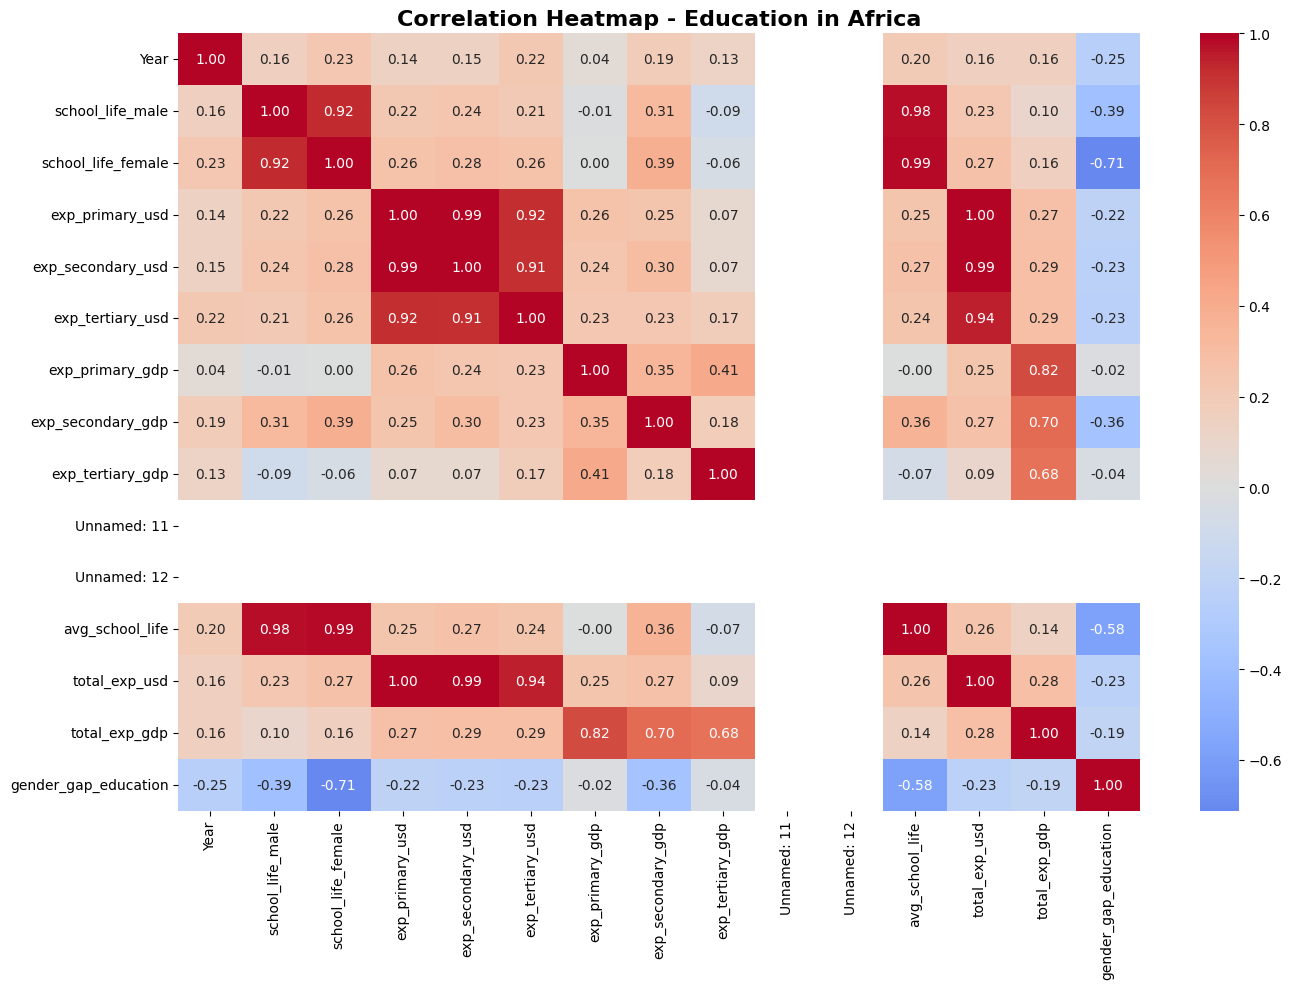

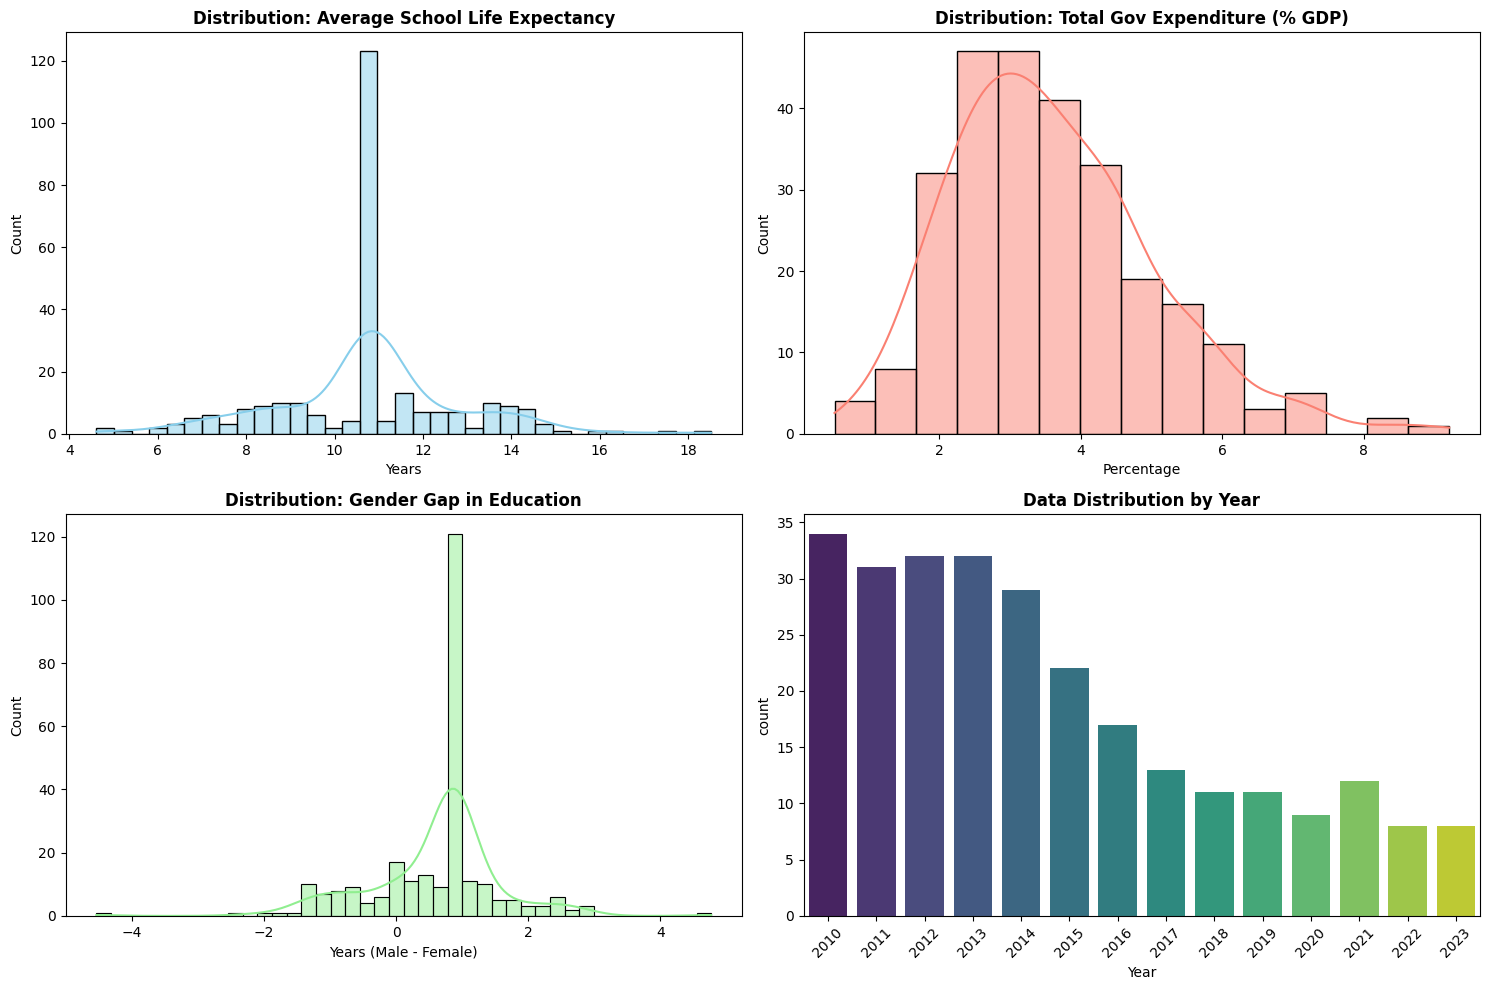


CORRELATIONS WITH TARGET (avg_school_life)
avg_school_life         1.000000
school_life_female      0.985805
school_life_male        0.975497
exp_secondary_gdp       0.362854
exp_secondary_usd       0.265253
total_exp_usd           0.257171
exp_primary_usd         0.247870
exp_tertiary_usd        0.244682
Year                    0.201937
total_exp_gdp           0.136171
exp_primary_gdp        -0.003729
exp_tertiary_gdp       -0.073590
gender_gap_education   -0.583714
Unnamed: 11                  NaN
Unnamed: 12                  NaN
Name: avg_school_life, dtype: float64


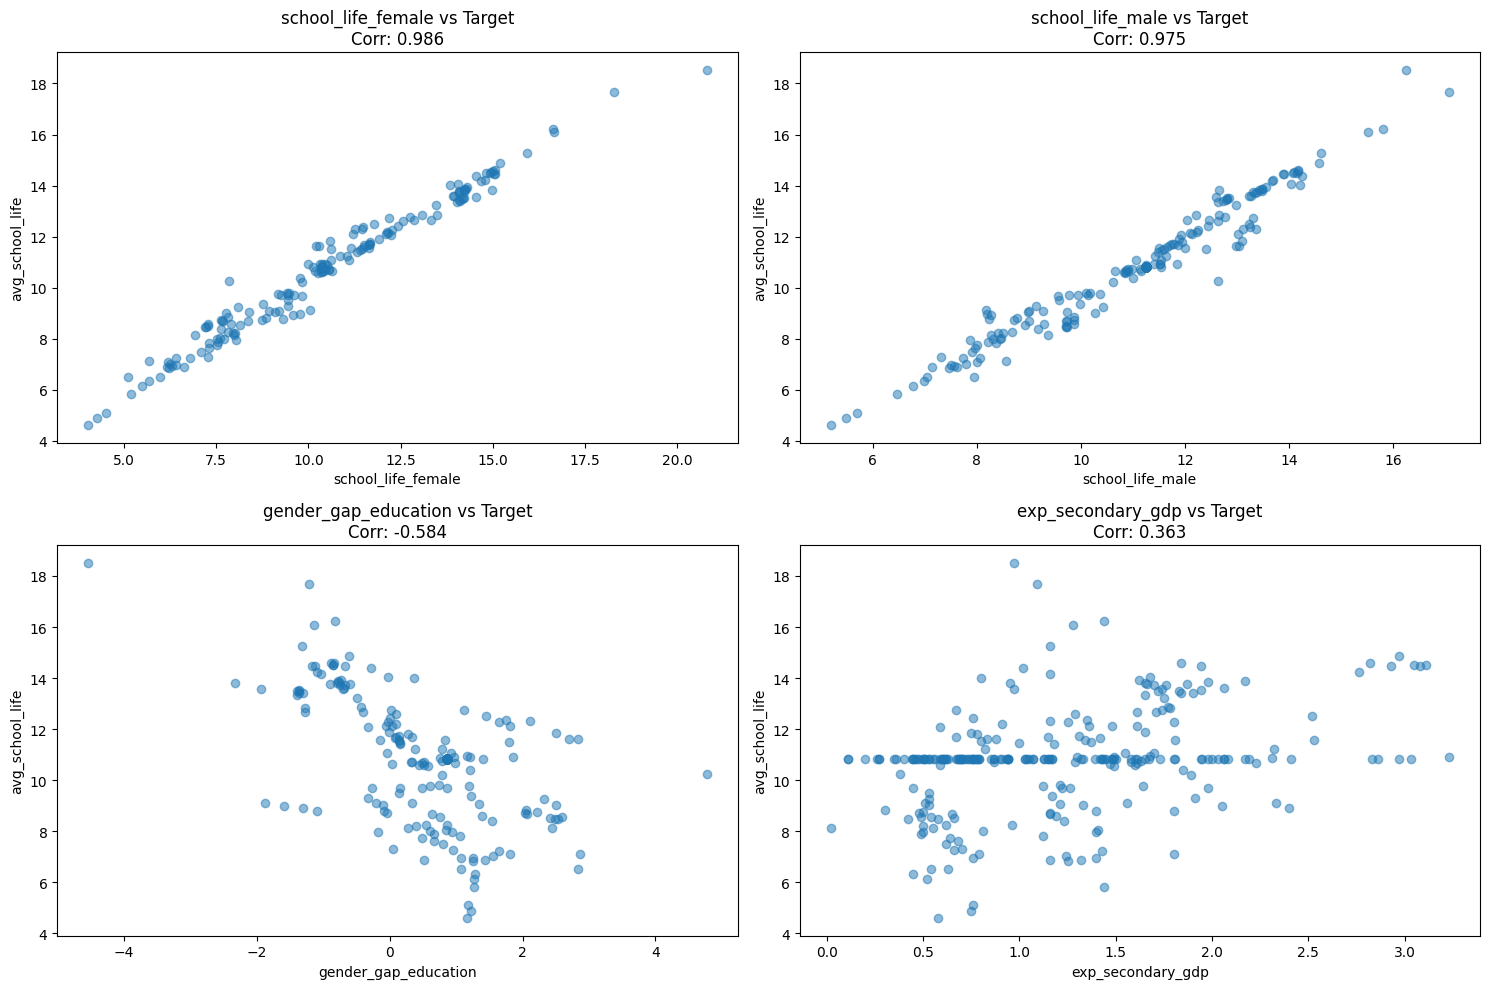


✓ EDA COMPLETE - Ready for modeling!
✓ Saved cleaned data to 'education_africa_cleaned.csv'


In [ ]:

# STEP 4: EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("STEP 4: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic statistics
print("\nDescriptive Statistics:")
print(df_clean.describe())

# Correlation heatmap
plt.figure(figsize=(14, 10))
numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Education in Africa', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution plots for key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Average School Life Expectancy
sns.histplot(df_clean['avg_school_life'].dropna(), kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution: Average School Life Expectancy', fontweight='bold')
axes[0, 0].set_xlabel('Years')

# Plot 2: Total Government Expenditure (GDP %)
sns.histplot(df_clean['total_exp_gdp'].dropna(), kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution: Total Gov Expenditure (% GDP)', fontweight='bold')
axes[0, 1].set_xlabel('Percentage')

# Plot 3: Gender Gap
sns.histplot(df_clean['gender_gap_education'].dropna(), kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution: Gender Gap in Education', fontweight='bold')
axes[1, 0].set_xlabel('Years (Male - Female)')

# Plot 4: Year distribution
sns.countplot(data=df_clean, x='Year', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Data Distribution by Year', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation with target (avg_school_life)
print("\n" + "="*60)
print("CORRELATIONS WITH TARGET (avg_school_life)")
print("="*60)
correlations = numeric_df.corr()['avg_school_life'].sort_values(ascending=False)
print(correlations)

# Scatter plots of top features vs target
top_features = correlations.drop('avg_school_life').abs().nlargest(4).index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(df_clean[feature], df_clean['avg_school_life'], alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('avg_school_life')
    axes[idx].set_title(f'{feature} vs Target\nCorr: {correlations[feature]:.3f}')

plt.tight_layout()
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✓ EDA COMPLETE - Ready for modeling!")
print("="*60)

# Save cleaned data
df_clean.to_csv('education_africa_cleaned.csv', index=False)
print("✓ Saved cleaned data to 'education_africa_cleaned.csv'")

EDUCATION IN AFRICA - PREDICTIVE MODELING
Mission: Predict School Life Expectancy Based on Government Investment

✓ Loaded cleaned dataset: (269, 17)

FEATURE SELECTION
Target Variable: avg_school_life
Features (5):
  - Year
  - exp_primary_gdp
  - exp_secondary_gdp
  - exp_tertiary_gdp
  - total_exp_gdp

✓ Final dataset for modeling: (269, 5)
✓ Target distribution: min=4.61, max=18.52, mean=10.77

TRAIN-TEST SPLIT
Training set: (215, 5)
Test set: (54, 5)

FEATURE STANDARDIZATION
✓ Features standardized (mean=0, std=1)
Scaler mean: [2.01454419e+03 1.58827907e+00 1.21055814e+00 7.54558140e-01
 3.55339535e+00]
Scaler scale: [3.66969375 0.71465088 0.64936081 0.53251895 1.41253693]
✓ Saved scaler to 'scaler.pkl'

MODEL 1: LINEAR REGRESSION
Train MSE: 3.5367
Test MSE:  3.5555
Train R²:  0.1922
Test R²:   0.1128

Feature Coefficients:
  Year                          :   0.2456
  exp_primary_gdp               :  -0.2731
  exp_secondary_gdp             :   0.8294
  exp_tertiary_gdp            

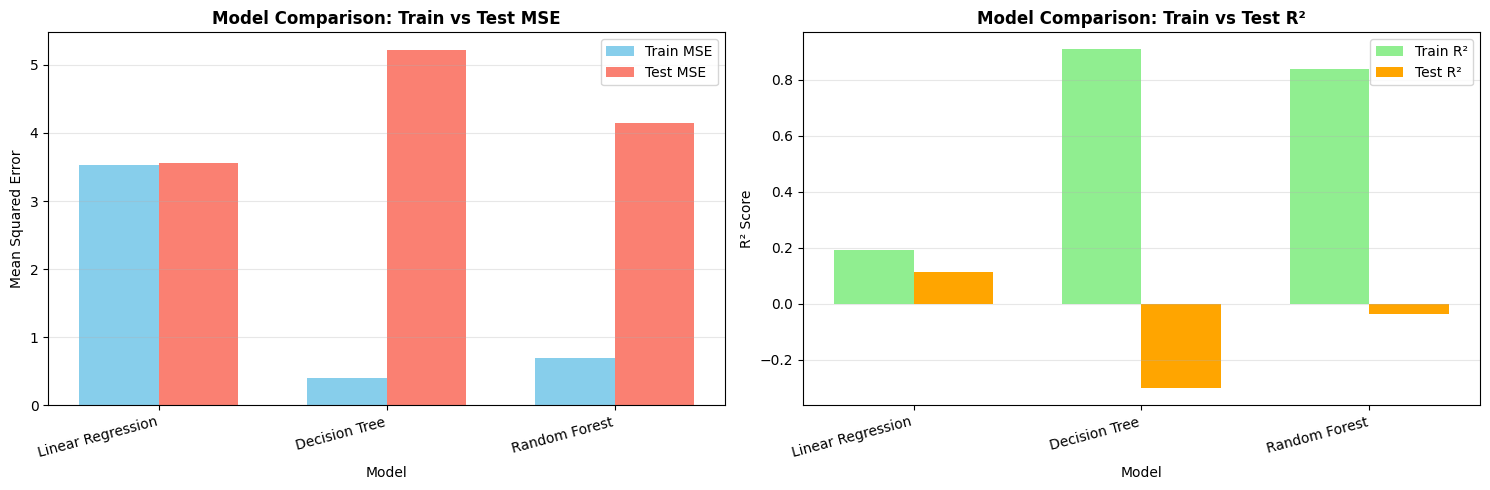

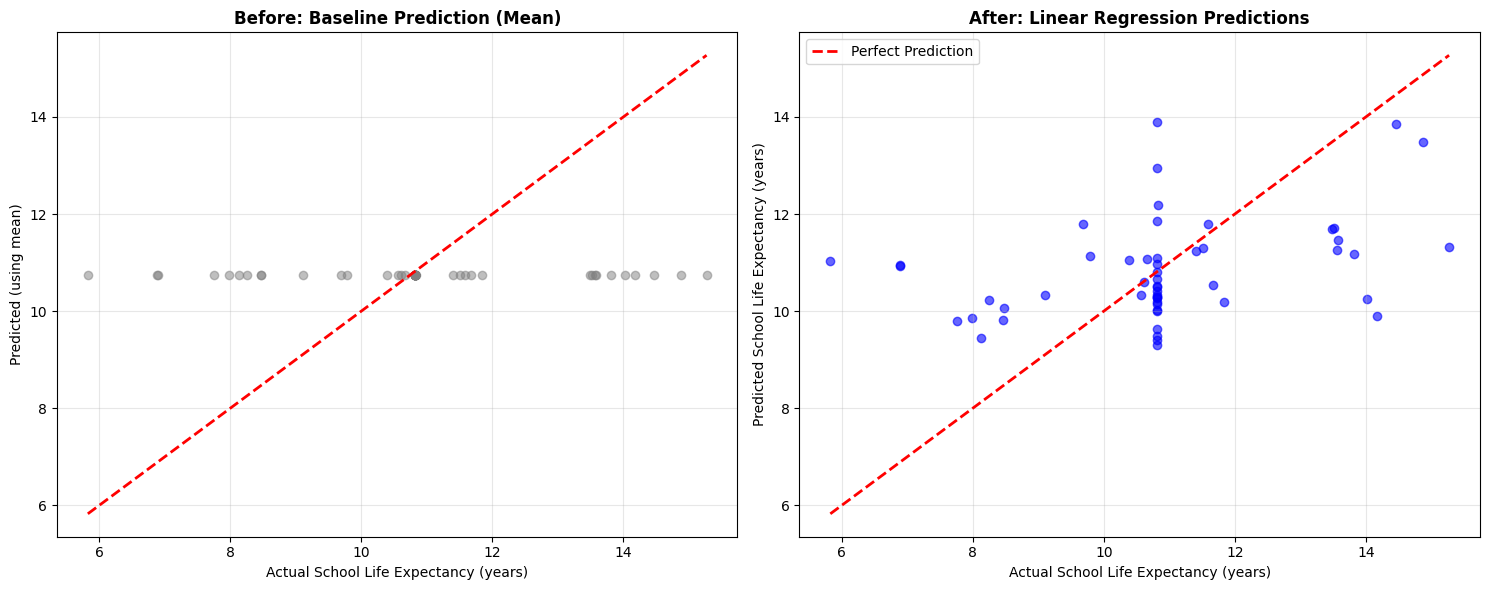

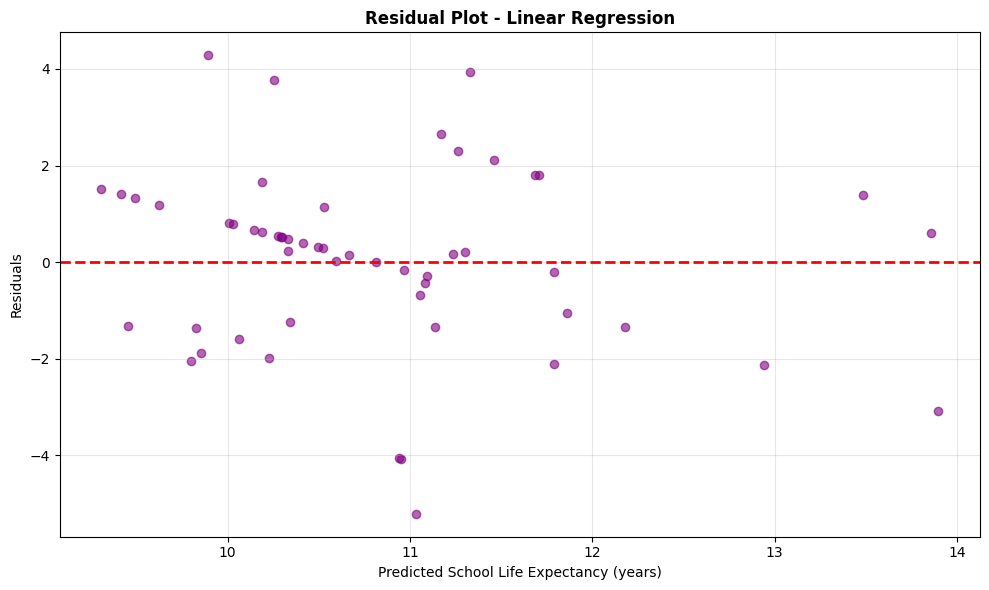


SAVING BEST MODEL
✓ Saved Linear Regression to 'best_model.pkl'
✓ Saved feature names to 'feature_names.pkl'

TEST PREDICTION ON SINGLE DATA POINT

Sample Input:
    Year  exp_primary_gdp  exp_secondary_gdp  exp_tertiary_gdp  total_exp_gdp
30  2010             1.47               1.16              1.68           4.31

Actual School Life Expectancy: 14.18 years
Predicted School Life Expectancy: 9.89 years
Error: 4.28 years

PREDICTION FUNCTION FOR API

✓ Test Prediction: 11.67 years

✓ MODELING COMPLETE!

Files saved:
  - best_model.pkl
  - scaler.pkl
  - feature_names.pkl
  - correlation_heatmap.png
  - distributions.png
  - feature_relationships.png
  - model_comparison.png
  - predictions_comparison.png
  - residuals.png


In [ ]:
print("="*70)
print("EDUCATION IN AFRICA - PREDICTIVE MODELING")
print("Mission: Predict School Life Expectancy Based on Government Investment")
print("="*70)

# ============================================
# LOAD CLEANED DATA
# ============================================
df = pd.read_csv('education_africa_cleaned.csv')
print(f"\n✓ Loaded cleaned dataset: {df.shape}")

# ============================================
# FEATURE SELECTION
# ============================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

# Target variable
target = 'avg_school_life'

# Features to use for prediction
features = [
    'Year',
    'exp_primary_gdp',
    'exp_secondary_gdp',
    'exp_tertiary_gdp',
    'exp_primary_usd',
    'exp_secondary_usd',
    'exp_tertiary_usd',
    'total_exp_gdp',
    'school_life_male',
    'school_life_female'
]

# Remove features that leak information about target
# (male/female school life are too closely related to average)
features_final = [
    'Year',
    'exp_primary_gdp',
    'exp_secondary_gdp',
    'exp_tertiary_gdp',
    'total_exp_gdp'
]

print(f"Target Variable: {target}")
print(f"Features ({len(features_final)}):")
for f in features_final:
    print(f"  - {f}")

# Prepare X and y
X = df[features_final].copy()
y = df[target].copy()

# Remove any remaining NaN
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\n✓ Final dataset for modeling: {X.shape}")
print(f"✓ Target distribution: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

# ============================================
# TRAIN-TEST SPLIT
# ============================================
print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ============================================
# FEATURE STANDARDIZATION
# ============================================
print("\n" + "="*70)
print("FEATURE STANDARDIZATION")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized (mean=0, std=1)")
print(f"Scaler mean: {scaler.mean_}")
print(f"Scaler scale: {scaler.scale_}")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Saved scaler to 'scaler.pkl'")

# ============================================
# MODEL 1: LINEAR REGRESSION
# ============================================
print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION")
print("="*70)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print(f"Train MSE: {lr_train_mse:.4f}")
print(f"Test MSE:  {lr_test_mse:.4f}")
print(f"Train R²:  {lr_train_r2:.4f}")
print(f"Test R²:   {lr_test_r2:.4f}")

# Feature importance (coefficients)
print("\nFeature Coefficients:")
for feature, coef in zip(features_final, lr_model.coef_):
    print(f"  {feature:30s}: {coef:8.4f}")

# ============================================
# MODEL 2: DECISION TREE
# ============================================
print("\n" + "="*70)
print("MODEL 2: DECISION TREE REGRESSOR")
print("="*70)

dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Metrics
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print(f"Train MSE: {dt_train_mse:.4f}")
print(f"Test MSE:  {dt_test_mse:.4f}")
print(f"Train R²:  {dt_train_r2:.4f}")
print(f"Test R²:   {dt_test_r2:.4f}")

# Feature importance
print("\nFeature Importances:")
for feature, importance in zip(features_final, dt_model.feature_importances_):
    print(f"  {feature:30s}: {importance:.4f}")

# ============================================
# MODEL 3: RANDOM FOREST
# ============================================
print("\n" + "="*70)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*70)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Metrics
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print(f"Train MSE: {rf_train_mse:.4f}")
print(f"Test MSE:  {rf_test_mse:.4f}")
print(f"Train R²:  {rf_train_r2:.4f}")
print(f"Test R²:   {rf_test_r2:.4f}")

# Feature importance
print("\nFeature Importances:")
for feature, importance in zip(features_final, rf_model.feature_importances_):
    print(f"  {feature:30s}: {importance:.4f}")

# ============================================
# MODEL COMPARISON
# ============================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'Train MSE': [lr_train_mse, dt_train_mse, rf_train_mse],
    'Test MSE': [lr_test_mse, dt_test_mse, rf_test_mse],
    'Train R²': [lr_train_r2, dt_train_r2, rf_train_r2],
    'Test R²': [lr_test_r2, dt_test_r2, rf_test_r2]
})

print(results.to_string(index=False))

# Best model
best_model_idx = results['Test MSE'].idxmin()
best_model_name = results.loc[best_model_idx, 'Model']
best_test_mse = results.loc[best_model_idx, 'Test MSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test MSE: {best_test_mse:.4f}")

# Select best model
if best_model_name == 'Linear Regression':
    best_model = lr_model
    y_test_pred_best = y_test_pred_lr
    y_train_pred_best = y_train_pred_lr
elif best_model_name == 'Decision Tree':
    best_model = dt_model
    y_test_pred_best = y_test_pred_dt
    y_train_pred_best = y_train_pred_dt
else:
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
    y_train_pred_best = y_train_pred_rf

# ============================================
# VISUALIZATION: LOSS CURVES
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Model Comparison - MSE
ax1 = axes[0]
x_pos = np.arange(len(results))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, results['Train MSE'], width, label='Train MSE', color='skyblue')
bars2 = ax1.bar(x_pos + width/2, results['Test MSE'], width, label='Test MSE', color='salmon')

ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Model Comparison: Train vs Test MSE', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: R² Score Comparison
ax2 = axes[1]
bars3 = ax2.bar(x_pos - width/2, results['Train R²'], width, label='Train R²', color='lightgreen')
bars4 = ax2.bar(x_pos + width/2, results['Test R²'], width, label='Test R²', color='orange')

ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('Model Comparison: Train vs Test R²', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results['Model'], rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SCATTER PLOT: ACTUAL VS PREDICTED
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before (just using mean as predictor)
ax1 = axes[0]
y_mean = y_train.mean()
ax1.scatter(y_test, [y_mean]*len(y_test), alpha=0.5, color='gray')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual School Life Expectancy (years)')
ax1.set_ylabel('Predicted (using mean)')
ax1.set_title('Before: Baseline Prediction (Mean)', fontweight='bold')
ax1.grid(alpha=0.3)

# After (best model)
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred_best, alpha=0.6, color='blue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual School Life Expectancy (years)')
ax2.set_ylabel('Predicted School Life Expectancy (years)')
ax2.set_title(f'After: {best_model_name} Predictions', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# RESIDUAL PLOT
# ============================================
residuals = y_test - y_test_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_best, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted School Life Expectancy (years)')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_name}', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SAVE BEST MODEL
# ============================================
print("\n" + "="*70)
print("SAVING BEST MODEL")
print("="*70)

joblib.dump(best_model, 'best_model.pkl')
print(f"✓ Saved {best_model_name} to 'best_model.pkl'")

# Save feature names
joblib.dump(features_final, 'feature_names.pkl')
print("✓ Saved feature names to 'feature_names.pkl'")

# ============================================
# TEST PREDICTION FUNCTION
# ============================================
print("\n" + "="*70)
print("TEST PREDICTION ON SINGLE DATA POINT")
print("="*70)

# Take one sample from test set
sample_idx = 0
sample_input = X_test.iloc[sample_idx:sample_idx+1]
actual_value = y_test.iloc[sample_idx]

print(f"\nSample Input:")
print(sample_input)

# Scale and predict
sample_scaled = scaler.transform(sample_input)
prediction = best_model.predict(sample_scaled)[0]

print(f"\nActual School Life Expectancy: {actual_value:.2f} years")
print(f"Predicted School Life Expectancy: {prediction:.2f} years")
print(f"Error: {abs(actual_value - prediction):.2f} years")

# ============================================
# CREATE PREDICTION FUNCTION FOR API
# ============================================
print("\n" + "="*70)
print("PREDICTION FUNCTION FOR API")
print("="*70)

def predict_school_life(year, exp_primary_gdp, exp_secondary_gdp,
                        exp_tertiary_gdp, total_exp_gdp):
    """
    Predict school life expectancy based on government expenditure.

    Parameters:
    -----------
    year : int
        Year of data
    exp_primary_gdp : float
        Gov expenditure on primary education as % of GDP
    exp_secondary_gdp : float
        Gov expenditure on secondary education as % of GDP
    exp_tertiary_gdp : float
        Gov expenditure on tertiary education as % of GDP
    total_exp_gdp : float
        Total gov expenditure on education as % of GDP

    Returns:
    --------
    float : Predicted school life expectancy in years
    """
    # Load model and scaler
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')

    # Create input array
    input_data = np.array([[year, exp_primary_gdp, exp_secondary_gdp,
                           exp_tertiary_gdp, total_exp_gdp]])

    # Scale and predict
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]

    return round(prediction, 2)

# Test the function
test_prediction = predict_school_life(
    year=2020,
    exp_primary_gdp=2.5,
    exp_secondary_gdp=1.8,
    exp_tertiary_gdp=0.7,
    total_exp_gdp=5.0
)

print(f"\n✓ Test Prediction: {test_prediction} years")

print("\n" + "="*70)
print("✓ MODELING COMPLETE!")
print("="*70)
print("\nFiles saved:")
print("  - best_model.pkl")
print("  - scaler.pkl")
print("  - feature_names.pkl")
print("  - correlation_heatmap.png")
print("  - distributions.png")
print("  - feature_relationships.png")
print("  - model_comparison.png")
print("  - predictions_comparison.png")
print("  - residuals.png")